# Footprint Viewer
***
## Learning Goals

## Introduction
This Notebook is a replacement for a web-based footprint viewer.

Eventually, footprint viewing functionality will be built into the [Astronomer's Proposal Tool (APT)](https://www.stsci.edu/scientific-community/software/astronomers-proposal-tool-apt); scientists intending to propose for observations should use APT. 



## Imports
- `selectSIAF` is a script that hides some of the complexities of this Notebook. Curious readers may wish to explore this file.
- `numpy` is not listed in the import cell, but is necessary to run the `selectSIAF` script
- `ipyaladin` plots the footprints on to a survey background

In [39]:
###############################################################
# ASB-25623 Notebook to display Telescope/Instrument footprints on sky viewer
#
# ASB-25623     Brian McLean    Initial prototype v0.1 2024-02-29
###############################################################
from astroquery.mast import Mast
from ipyaladin import Aladin
from selectSIAF import defineApertures, getVertices, computeStcsFootprint

import matplotlib.pyplot as plt
import pysiaf

## Select a Telescope, Instrument, and Aperture
In order to display a fooprint, we must first select three criteria:
1. Telescope. This must be a telescope with data in [pysiaf](https://pysiaf.readthedocs.io/en/stable/index.html); at present, this is HST, JWST, and Roman.
2. Instrument. The instrument used for the observation. The valid acronyms are listed in code comments in the cell below.
3. Aperture. For a full list of valid apertures, see the instrument documentation:

- [HST User Documentation Homepage](https://hst-docs.stsci.edu)
- [JWST MIRI Homepage](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument) (JWST has no instrument homepage; use the site navigation too reach other instrument pages)
- [Roman Instruments Homepage](https://roman-docs.stsci.edu/roman-instruments-home)

### Example: Roman WFI
In the code cell below, we'll set some variables to hold these three selections. For completeness, examples for HST and JWST and available but commented out.

In [197]:
# define telescope pointing at target

# selectedTelescope = 'roman'
# selectedInstrument = 'WFI'      #Allowed options ALL, WFI, CGI
# selectedAperture = 'ALL'        #Allowed options ALL or individual apertures listed in instrument documentation

# selectedTelescope = 'hst'
# selectedInstrument = 'ALL'     #Allowed options ALL, ACS, COS, FGS, NICMOS, STIS, WFC3
# selectedAperture = 'ALL'       #Allowed options ALL or individual apertures listed in instrument documentation

selectedTelescope = 'jwst'
selectedInstrument = "MIRI"     #Allowed options ALL, FGS, MIRI, NIRCAM, NIRSPEC, NIRISS
selectedAperture = 'ALL'       #Allowed options ALL or individual apertures listed in instrument documentation

## Specifying a Target
For convenience, we can use the `resolve_object` function from the MAST library to get our coordinates.

In [95]:
# Resolve the target name to coordinates
coords = Mast.resolve_object("M101")
coords

<SkyCoord (ICRS): (ra, dec) in deg
    (210.802429, 54.34875)>

Using MAST to resolve our target returns a [skycoord](https://docs.astropy.org/en/stable/coordinates/) object. We need two different formats to satisfy `pysiaf` and `Aladin`. `pysiaf` requires separate ra/dec objects, while `Aladin` is looking for a string containing both.

Fortunately, `skycoord` objects are flexible enough to handle both of these requirements with straightforward calls:

In [104]:
# get the values for SIAF
targetRa = coords.ra
targetDec = coords.dec

coords_str = coords.to_string()

# print out these values to check their conversions
print(f"RA:     {targetRa}\nDEC:    {targetDec}\nString: {coords_str}")

RA:     210.802429 deg
DEC:    54.34875 deg
String: 210.802 54.3488


There's a little bit of rounding as a result of our `to_string()` call. As we'll see later on, we only need the string to point the Aladin viewer at the right section of the sky; a little bit of rounding won't hurt us in this case.

## Telescope Position Angle

The last variable we need to set before using `pysiaf` is the telescope position angle. From the docstring of the `attitude_matrix` function:
>Position angle of V3 axis at nu2,nu3 measured from North to East (default unit is degree)

In plain Enligsh, this is the telescope roll angle; modifying this value will cause the footprints to "roll" around the target.

In [179]:
# can be any value between 0 and 360
telescopePositionAngle = 180

## Generate Apertures, Reference Angles, and Pointing Matrix
`psiaf` is also expecting us to pass in the aperture names and appropriate reference angles. This is a bit beyond the scope of this Notebook, but the `defineApertures` is available in the `selectSIAF.py` file included in the Notebook repository.

In [198]:
# Set up aperture list and reference coordinates
apertureList, V2Ref, V3Ref = defineApertures(selectedTelescope, selectedInstrument, selectedAperture)

# Set telescope pointing matrix: "attitude matrix"
attmat = pysiaf.utils.rotations.attitude_matrix(V2Ref, V3Ref, targetRa, targetDec, telescopePositionAngle)

## Optional: Plot Footprint in Telescope Frame

Although not necessary to generate the final plot, it is possible to show the telescope apertures plotted relative to the boresight.

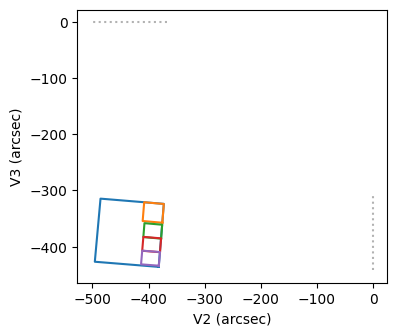

In [199]:
# OPTIONAL : set up plot of apertures (only works for QUAD, RECT, PICK aperture shapes)

plt.figure(figsize=(4, 4), facecolor='w', edgecolor='k')
ax = plt.gca()

for aperture in apertureList:
    # circles are not properly plotted, skip
    if aperture.AperShape!='CIRC':
        aperture.plot()


# Add guide lines for boresight (V2, V3) = (0, 0)
ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.plot([0, 0], [min(ylim), max(ylim)], color='black', linestyle=':', alpha=0.3)
ax.plot(xlim, [0, 0], color='black', linestyle=':', alpha=0.3)

# Set the axis limits and invert the X-axis such that V2 is positive to the left
ax.invert_xaxis()

# Display the plot
plt.show() 

## Calculate Sky Regions

The final step is to convert to an [IVOA Space-Time Coordinate Metadata Linear String Implementation (STS-C)](https://ivoa.net/documents/STC-S/). This is our footprint! Since `Aladin` knows how to parse this format, it will be able to plot it on a sky background of our choice. It is not particularly human readable, but we'll print it out anyway.

In [180]:
# Loop through aperture list  (only works for QUAD, RECT, CIRC aperture shapes)
# Transform to sky coordinates, build footprints for passing to Aladin

combinedSregion=''
for apertureSiaf in apertureList[:-2]:
    apertureSiaf.set_attitude_matrix(attmat)
    xVertices, yVertices = getVertices(apertureSiaf)
    
    # Skip PICK which do not have vertices
    if (xVertices is not None and yVertices is not None):
        skyRa, skyDec = apertureSiaf.idl_to_sky(xVertices, yVertices)
        apertureSregion = computeStcsFootprint(apertureSiaf, skyRa, skyDec)
        combinedSregion+=apertureSregion
        
print('\n'+combinedSregion)

Unsupported shape  PICK
Unsupported shape  PICK
Unsupported shape  PICK

POLYGON ICRS 210.72632920 54.27841635 210.62993782 54.28041483 210.62833213 54.30832543 210.72339352 54.30565068 POLYGON ICRS 210.72873815 54.24955228 210.63144649 54.25080600 210.62992081 54.27968271 210.72629787 54.27772426 POLYGON ICRS 210.69755078 54.22145727 210.71125451 54.22063190 210.71131207 54.21357137 210.69749255 54.21438093 POLYGON ICRS 210.69647005 54.22277212 210.71270939 54.22189441 210.71283184 54.21333405 210.69640761 54.21424931 CIRCLE ICRS 210.6927088782195 54.50704029112318 0.011666666666666667 POLYGON ICRS 210.93924401 54.26773828 210.94291874 54.26555952 210.94665583 54.26770909 210.94298110 54.26988796 POLYGON ICRS 210.94622370 54.26226569 210.95272029 54.25851192 210.95919802 54.26233611 210.95270142 54.26609023 POLYGON ICRS 210.90211194 54.28310205 210.91949289 54.27295482 210.93692217 54.28312662 210.91954123 54.29327636 CIRCLE ICRS 211.05240762797428 54.40872598965958 0.0197965555555555

## Initialize Aladin
Let's start the Aladin viewer. We're loading a default field of view of 1 degree, with DSS as the background survey.

Depending on your screen size, you may need to adjust the `height` (in pixels) to get the best view.

**NOTE:** The footprint will not show up right up away!

In [ ]:
aladin = Aladin(height=600,fov=1, survey="P/DSS2/color", target=coords_str)
aladin

This looks great, but where's our footprint? Well, we can only add an overlay once `Aladin` is already up and running. Let's add it now:

In [210]:
# Add the footprint in green; the specific color is your choice
aladin.add_overlay_from_stcs(combinedSregion,{"color":"green"})

Done! Our footprint should be visible now.

## About this Notebook

If you have comments or questions on this notebook, please contact us through the Archive Help Desk e-mail at archive@stsci.edu.

**Authors:** Brian McLean, Thomas Dutkiewicz <br>
**Keywords:** Footprints <br>
**Last Updated:** Mar 2024 <br>

***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 